In [1]:
# Generate data for SVM classifier with L1 regularization.
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 45
X = np.random.normal(0, 5, size=(m,n))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))
X_test = np.random.normal(0, 5, size=(TEST,n))
Y_test = np.sign(X_test.dot(beta_true) + offset + np.random.normal(0,sigma,size=(TEST,1)))

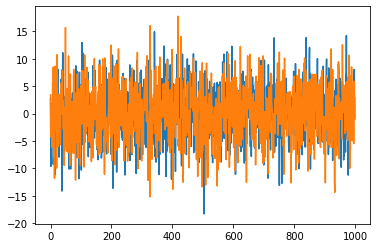

In [2]:
plt.plot(X[:,3])
plt.plot(X_test[:,3])
plt.show()

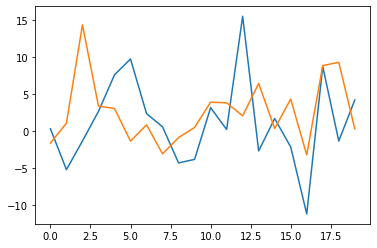

In [3]:
plt.plot(X[0,:])
plt.plot(X_test[0,:])
plt.show()

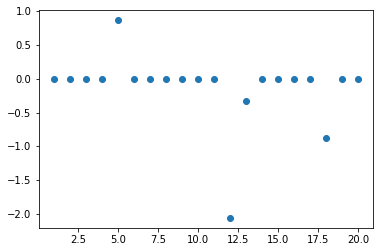

In [4]:
plt.scatter(np.linspace(1, 20, 20), beta_true)
plt.show()

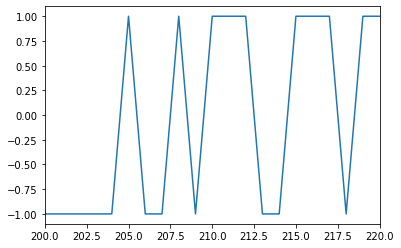

In [5]:
plt.plot(Y[:,0])
plt.xlim(200,220)
plt.show()

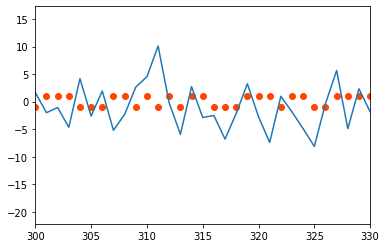

In [6]:
plt.scatter(np.linspace(0,999,1000), Y_test[:,0], c='orangered')
plt.plot(X_test[:,0])
plt.xlim(300,330)
plt.show()

In [7]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [8]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
v_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST
    beta_vals.append(beta.value)
    v_vals.append(v.value)

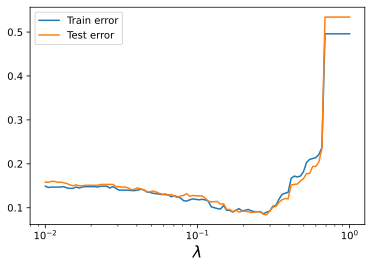

In [9]:
# Plot the train and test error over the trade-off curve.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

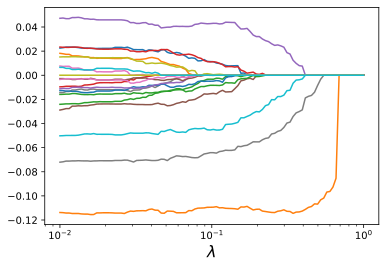

In [10]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lambda_vals, [wi[i,0] for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

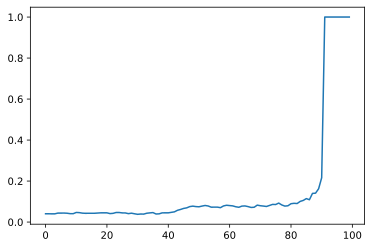

In [11]:
plt.plot(v_vals)

# Notes

We have an $\ell_1$ regularized average hinge loss problem
$$ f(\beta, v) = \frac{1}{m} \sum_i^m (1 - y_i(\beta^T x_i - v) + \lambda \|\beta\|_1, $$
where $x_i$ are data vectors, (e.g., time domain data,) $y_i$ are labels for $x_i$ (each $x_{i,k}$ has either $y_{i,k} = -1$ or $1$, assigning the element to one of two groups), $\lambda$ is a regularization parameter and $\beta$ and $v$ are unknown parameters to be learned by solving the optimization problem. The trained SVM can be used to then categorize datapoints into two sets by calculating
$$ y_i = \beta^T x_i - v, $$
where the sign of elements of $y$ tell if a datapoint is an outlier or not.

In [21]:
def get_outlier_data(ns=1000, show_plot=False):
    # Parameters
    num_samples = ns  # Number of samples
    constant_signal = 0  # Constant signal value
    noise_mean = 0  # Mean of the Gaussian noise
    noise_std = 1  # Standard deviation of the Gaussian noise
    num_outliers = 20  # Number of outliers
    outlier_magnitude = 20  # Magnitude of the outliers

    # Generate time domain data
    time = np.arange(num_samples)
    constant_component = np.full(num_samples, constant_signal)

    # Generate Gaussian noise
    noise = np.random.normal(noise_mean, noise_std, num_samples)

    # Add noise to the constant signal
    noisy_data = constant_component + noise

    # Generate random indices for outliers
    outlier_indices = np.random.choice(num_samples, num_outliers, replace=False)

    # Add outliers
    noisy_data[outlier_indices] += outlier_magnitude
    
    # Outlier labels
    labels = np.ones(num_samples) 
    for idx in outlier_indices:
        labels[idx] = -1

    if show_plot:
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.plot(time, noisy_data, label='Noisy Data')
        plt.plot(time, constant_component, label='Constant Component', linestyle='--')
        plt.scatter(outlier_indices, noisy_data[outlier_indices], color='red', label='Outliers')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Noisy Time Domain Data with Outliers')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return noisy_data, labels, outlier_indices

In [22]:
xs = np.zeros((m,n))
ys = np.zeros((m,n))
for i in range(n):
    xs[:,i], ys[:,i], _ = get_outlier_data(ns=m)

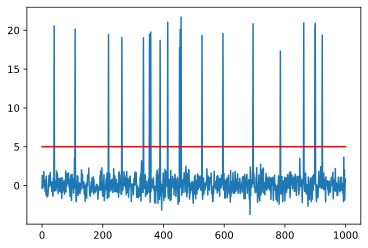

In [25]:
plt.plot(xs[:,0])
plt.plot([0, 1000], [5, 5], c='red')
plt.show()

In [14]:
w = cp.Variable((n,1))
b = cp.Variable()
hinge_loss = cp.sum(cp.pos(1 - cp.multiply(ys, xs @ w - b)))
#reg1 = cp.norm(w, 1)  # l1 constraint: w is sparse
reg1 = cp.norm(w, 2)**2  # (l2)^2 constraint: soft margin classifier
lamda = cp.Parameter(nonneg=True)
prblm = cp.Problem(cp.Minimize(hinge_loss/m + lamda*reg1))

In [15]:
# Compute a trade-off curve and record train and test error.
tries = 100
lamda_vals = np.logspace(-2, 0, tries)
w_vals = []
b_vals = []
for i in range(TRIALS):
    lamda.value = lamda_vals[i]
    prblm.solve()
    w_vals.append(w.value)
    b_vals.append(b.value)

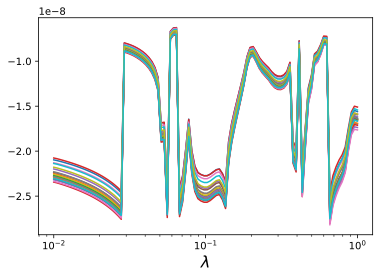

In [16]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lamda_vals, [wi[i,0] for wi in w_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")